In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

In [2]:
dataset = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
dataset

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [3]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [4]:
dataset=dataset.drop(columns=['Timestamp'])

In [5]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=7, min_periods=1,\
center=False).mean()
# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=70, min_periods=1,\
center=False).mean()
# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] >
dataset['long_mavg'], 1.0, 0.0)

In [6]:
dataset.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0


# Feature engineering

# Moving average
A moving average provides an indication of a price trend by cutting down the
amount of noise in the series.
# Stochastic oscillator %K
A stochastic oscillator is a momentum indicator that compares the closing price
of a security to a range of its previous prices over a certain period of time. %K
and %D are slow and fast indicators. The fast indicator is more sensitive than the
slow indicator to changes in the price of the underlying security and will likely
result in many transaction signals.
# Relative strength index (RSI)
This is a momentum indicator that measures the magnitude of recent price
changes to evaluate overbought or oversold conditions in the price of a stock or
other asset. The RSI ranges from 0 to 100. An asset is deemed to be overbought
once the RSI approaches 70, meaning that the asset may be getting overvalued
and is a good candidate for a pullback. Likewise, if the RSI approaches 30, it is an
indication that the asset may be getting oversold and is therefore likely to become
undervalued.
# Rate of change (ROC)
This is a momentum oscillator that measures the percentage change between the
current price and the n period past prices. Assets with higher ROC values are
considered more likely to be overbought; those with lower ROC, more likely to
be oversold.
# Momentum (MOM)
This is the rate of acceleration of a security’s price or volume—that is, the speed
at which the price is changing.

In [7]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_'+ str(n))
    return EMA
dataset['EMA14'] = EMA(dataset, 14)
dataset['EMA21'] = EMA(dataset, 21)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA14,EMA21,EMA200
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39,4.39,0.0,NaN,NaN,NaN


In [8]:
#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC14'] = ROC(dataset['Close'], 10)
dataset['ROC21'] = ROC(dataset['Close'], 30)

In [9]:
#calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM14'] = MOM(dataset['Close'], 14)
dataset['MOM21'] = MOM(dataset['Close'], 21)

In [10]:
#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)
dataset['RSI14'] = RSI(dataset['Close'], 14)
dataset['RSI21'] = RSI(dataset['Close'], 21)
dataset['RSI200'] = RSI(dataset['Close'], 200)

In [11]:
#calculation of stochastic osillator.
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
    low.rolling(n).min())) * 100
    return STOK
def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
    low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD
dataset['%K14'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 14)
dataset['%D14'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 14)
dataset['%K21'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 21)
dataset['%D21'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 21)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [12]:
#calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_'\
    + str(n))
    return MA
dataset['MA21'] = MA(dataset, 21)
dataset['MA63'] = MA(dataset,63)
dataset['MA200'] = MA(dataset, 200)

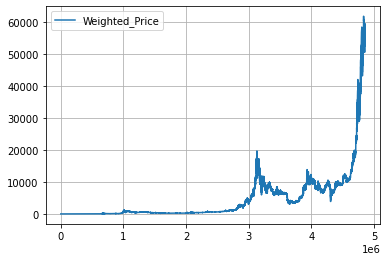

In [13]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show();

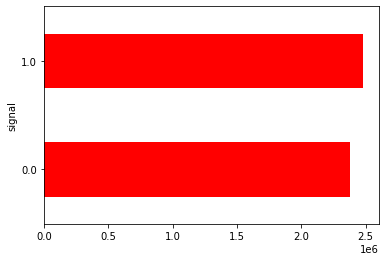

In [14]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

In [15]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation =\
train_test_split(X, Y, test_size=validation_size, random_state=1)

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,EMA14,...,RSI200,%K14,%D14,%K21,%D21,%K200,%D200,MA21,MA63,MA200
4836066,0.792607,0.788299,0.790945,0.788049,0.611006,0.899750,0.789995,0.787771,0.767019,0.786910,...,-0.516256,0.542675,1.104879,-0.551653,-0.315113,0.803481,0.906734,0.786395,0.770951,0.764498
4833800,1.385828,1.381446,1.383203,1.380282,-0.368112,-0.329167,1.381028,1.387255,1.408871,1.391905,...,-0.995331,-1.469639,-1.131193,-1.601187,-1.427163,-1.008537,-0.890072,1.396417,1.411885,1.418433


Variance preserved by first 5 components == 94.63%


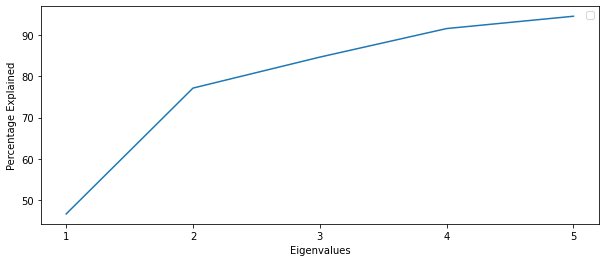

In [17]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))


In [18]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(80000, 5)


,c0,c1,c2,c3,c4
4836066,-2.801583,0.566961,0.217711,1.151212,-0.947557
4833800,-4.830900,-4.398147,-0.162799,-0.173414,0.538607
4844322,-4.091429,-1.524828,-0.127545,-0.385562,-0.333514
4814804,0.075922,-0.031552,1.812760,-0.640778,-0.180642
4791993,0.374484,-2.333476,0.926201,-0.191399,0.046696


# Basic Visualisation of Reduced Features

In [19]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

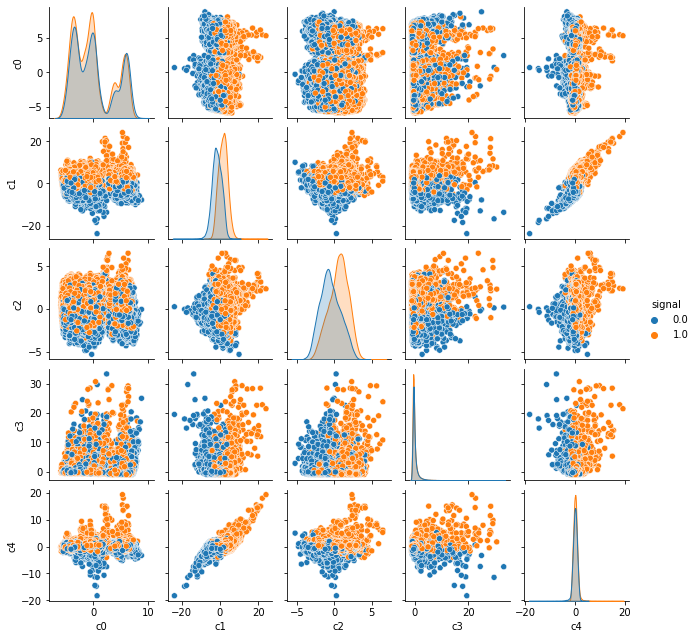

In [20]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)


In [21]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [22]:
dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)


interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

# t-SNE visualization

Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

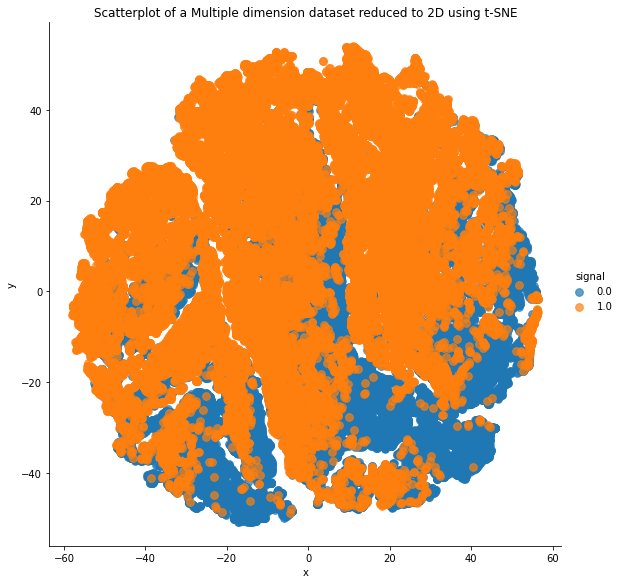

In [23]:
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['signal'] = Y_train
g = sns.lmplot('x', 'y', dftsne, hue='signal', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')


# Compare Models-with and without dimensionality Reduction

In [24]:
# test options for classification
scoring = 'accuracy'

# Models

In [26]:
from sklearn.ensemble import RandomForestClassifier
import time
start_time = time.time()
# spot check the algorithms
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=10, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))


Time Without Dimensionality Reduction--- 103.63360500335693 seconds ---


In [27]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=10, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))


Time with Dimensionality Reduction--- 49.048935413360596 seconds ---


In [28]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))


Result without dimensionality Reduction: 0.929100 (0.003845)
Result without dimensionality Reduction: 0.929100 (0.003845)
